# Data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

In [3]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_ditributions(catalog,
                       price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        sns.distplot(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values,
                     kde=i!=0 and i!=9, bins=15, ax=ax)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_model(inputs):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[inputs]),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    return model

def plot_history(model):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
        
    plt.plot(hist['epoch'], hist['loss'], label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
    plt.ylim([0,1])
    plt.legend()

    plt.show()

In [4]:
def compare_results(targets, y_limits, model_name):
    
    target = targets[0]
    predicted = targets[1]
    # Compare target and predicted values
    plt.figure(figsize=(10, 6));
    sns.regplot(x=target, y=predicted, marker="*", scatter_kws={"s": 80}, ci=68);
    plt.xlabel('Target price');
    plt.ylabel('Predicted price');
    plt.title('Predicted vs. target - ' + model_name)
    
    # Visualize prediction difference
    prediction_diff = target - predicted
    plt.figure(figsize=(10, 6));
    sns.scatterplot(np.arange(prediction_diff.shape[0]), prediction_diff, 
                    marker="*", s=150);
    plt.axhline(y=0, color='r', linestyle='-');
    plt.axhline(y=prediction_diff.mean(), color='m', linestyle='--');
    plt.ylim(y_limits[0], y_limits[1]);
    plt.xlabel('Target price');
    plt.ylabel('Target - Prediction');
    plt.title('diff(target, prediction) - ' + model_name)
    
    
def visualize_data(pca_data, targets, model_name, dr_type):
    
    # Visualize first PCs
    fig, axes = plt.subplots(1, 2, figsize=(18, 6));
    
    for idx, axis in enumerate(axes):
        sns.scatterplot(pca_data[:, 0], pca_data[:, 1],
                        marker="o", hue=targets[idx], s=100, ax=axis);
        axis.set_xlabel(dr_type + ' 1');
        axis.set_ylabel(dr_type + ' 2');
        axis.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False);
        if idx == 0:
            axis.set_title(dr_type + ' scores - target prices')
        else:
            axis.set_title(dr_type + ' scores - predicted prices, ' + model_name)
    
    
def perform_pca(data):
    # Scale data and perform PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    pca_model = PCA(n_components=0.95)
    data_pca = pca_model.fit_transform(data_scaled)
    return data_pca

In [5]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members_new.csv')

# Cleaning catalog

In [6]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows.')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows.')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows.
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows.
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows.
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows.
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows.

Totally removed 135 rows.


In [7]:
classEncoder = LabelEncoder()

catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
748,64817,3,0,3500,6,5
749,65041,1,0,0,1,6
750,65073,2,0,12250,8,4
751,65297,2,0,12500,8,5


In [8]:
print('Duplicates: ', catalog.duplicated().sum())
print('Missing values: ', catalog.isnull().sum())
print('Catalog shape: ', catalog.shape)

Duplicates:  0
Missing values:  item_cd              0
item_class           0
item_price_credit    0
item_price_gold      0
item_level           0
crew_size            0
dtype: int64
Catalog shape:  (753, 6)


In [9]:
s1 = set(removed_tanks['item_cd'])
s2 = set(data['vehicle_type_cd'])

removed_ids = s1.intersection(s2)
print(removed_ids)

{13889, 58625, 61697, 65281, 9297, 6225}


# Visualizing catalog

In [ ]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

In [ ]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

In [ ]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

In [ ]:
sns.countplot(catalog['item_level']);

In [ ]:
sns.countplot(catalog['crew_size']);

# Cleaning data

## Removing entries from "data" that corresponds to deleted tanks in "catalog"

In [10]:
mask = ~data['vehicle_type_cd'].isin(removed_ids)

removed_data = data.loc[~mask]
data = data.loc[mask]

data.reset_index(inplace=True, drop=True)
removed_data.reset_index(inplace=True, drop=True)

print('Removed number of rows: ', removed_data.shape[0])

Removed number of rows:  687


## Adding Categorical and DateTime features

In [11]:
data.loc[:, 'dt'] = pd.to_datetime(data['dt'])

## Checking duplicates and missing values

In [12]:
print('Duplicates in "data": ', data.duplicated().sum());
print('Missing values in "data":\n', data.isnull().sum());

Duplicates in "data":  0
Missing values in "data":
 dt                          0
arena_id                    0
periphery_id                0
account_db_id               0
team_id                     0
clan_db_id                  0
prebattle_id                0
is_prebattle_creator        0
vehicle_type_cd             0
life_time_sec               0
shots                       0
hits                        0
he_hits                     0
pierced                     0
damage_dealt                0
damage_assisted_radio       0
damage_assisted_stun        0
damage_assisted_track       0
damage_received             0
shots_received              0
no_damage_shots_received    0
pierced_received            0
spotted                     0
damaged                     0
kills_made                  0
mileage_meter               0
remained_hp                 0
original_credits            0
original_xp                 0
premium_xp_factor           0
daily_xp_factor             0
battle_num        

## Checking outliers

In [ ]:
def calculate_z_score(data):
    return stats.zscore(data)

Something does not work here, check later

In [ ]:
# features = data.columns.values
# z_scores = np.zeros((data.shape[0], len(features)))
# z_score_threshold = 3

# feature_outliers = dict.fromkeys(features)

# # z-scores for old features
# for index, feature in enumerate(features):
#     feature_outliers = calculate_z_score(data[feature])
    
#     z_scores[:, index] = feature_outliers
#     feature_outliers[feature] = data[feature_outliers > z_score_threshold]
    
#     print(feature, feature_outliers[feature].shape[0])
    
#     # Plotting feature distribution
#     fig, ax = plt.subplots()
#     sns.distplot(data[feature], kde=False);
#     plt.axvline(feature_outliers[feature][feature].min(), ymin=0, ymax=ax.get_ylim()[1])

# Visualizing data

## dt

All battles took place in October 2018 (between October 1 and October 31)

In [ ]:
data['dt'].describe()

## arena_id

47.363 unique battles were held.

45.479 battles should be 15 vs. 15 players!

There were 30 players in most battles (30 -> 20 -> 14). 
However, in some battles, a number of players was either odd (19, 13) or 
strangely small (2, 4). Are those battles connected to special events?

In [ ]:
battles = data['arena_id'].value_counts()
battles

In [ ]:
battles.to_frame()['arena_id'].value_counts()

## account_db_id

367.685 unique players took part in battles.

In [ ]:
data['account_db_id'].value_counts()

## life_time_sec

In [ ]:
sns.distplot(data['life_time_sec']);

## remained_hp

In [ ]:
data_negative_hp = data[data['remained_hp'] < 0]
data_negative_hp.shape[0]

## damage_dealt (total, assisted, etc.)

There are 1549 rows in a dataset that correspond to so-called "away-from-keyboard" players

In [ ]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

In [ ]:
data[(data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)]

## original_credits, original_xp, booster_bonus_xp, booster_bonus_credits

There is one player with original_credits < 0.

In [ ]:
data[data['original_credits'] < 0]

# Create new features (normalized to time/etc) 

In [13]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0
    
normalize_feature = np.vectorize(normalize_feature)

## Calculate additive features

In [14]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

data['damage_shots_received'] = data['shots_received'] - data['no_damage_shots_received']

Turns out that data['damage_shots_received'] = data['pierced_received'], so this feature is not added.

## Normalize to time

In [15]:
target_features = ['shots', 'hits', 'he_hits', 'pierced', 'damage_dealt', 
                   'damage_assisted_track', 'damage_assisted_radio', 
                   'damage_assisted_stun', 'total_damage_dealt',
                   'damage_received', 'shots_received', 
                   'pierced_received', 'spotted', 
                   'damaged', 'kills_made', 'mileage_meter',
                   'damage_blocked_by_armor']
# target_features_normalized_sec = [feature + '_per_sec' for feature in target_features]
target_features_normalized_min = [feature + '_per_min' for feature in target_features]

In [16]:
data['life_time_min'] = data['life_time_sec'] / 60

for feature in target_features:
#     data[feature + '_per_sec'] = normalize_feature(data[feature], data['life_time_sec'])
    data[feature + '_per_min'] = normalize_feature(data[feature], data['life_time_min'])

## Normalize to hits, shots, etc.

In [17]:
features_normalized = ['hit_rate', 'he_hit_rate', 'pierced_rate',
                      'damage_per_pierced', 'pierced_received_per_shot', 
                      'damage_per_enemy', 'damage_per_enemy_per_min', 
                      'damage_blocked_per_hit', 'damage_blocked_received_ratio']
features_num = ['hits', 'he_hits', 'pierced', 'damage_received', 
               'pierced_received', 'total_damage_dealt', 'total_damage_dealt_per_min', 
               'damage_blocked_by_armor', 'damage_blocked_by_armor']
features_denom = ['shots', 'hits', 'hits', 'pierced_received', 'shots_received', 
                 'damaged', 'damaged', 'pierced_received', 'damage_received']

In [18]:
for new_feature, feature_num, feature_denom in zip(features_normalized,
                                                  features_num, features_denom):
    data[new_feature] = normalize_feature(data[feature_num], data[feature_denom])

## Compare distributions before and after normalization

### Normalized to life_time_min

In [ ]:
for feature in target_features:
    new_feature = feature + '_per_min'

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].hist(data[feature], bins=40)
    axes[1].hist(data[new_feature], bins=40)
    
    axes[0].set_title(feature)
    axes[1].set_title(new_feature)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))
axes = axes.ravel()

for index, feature in enumerate(features_normalized):
    axes[index].hist(data[feature], bins=20);
    axes[index].set_title(feature)

## Calculate features that are based on winrates

### Add is_winner

In [19]:
def calc_winner(row):
    winner = 0
    if row['num_tanks_pos_1'] != 0 and row['num_tanks_pos_2'] == 0:
        winner = 1
    elif row['num_tanks_pos_2'] != 0 and row['num_tanks_pos_1'] == 0:
        winner = 2
    else:
        if row['mean_xp_1'] / row['mean_xp_2'] > 1.8:
            winner = 1
        elif row['mean_xp_2'] / row['mean_xp_1'] > 1.8:
            winner = 2
        else:
            winner = 0     
    return winner

In [20]:
data['is_alive'] = data['remained_hp'] > 0

# Getting data on full teams
warriors = data[data.groupby('arena_id')['account_db_id'].transform('count') == 30]
warriors.index = np.arange(len(warriors))
    
# Grouping teams by battles
battles = warriors.groupby(['arena_id', 'team_id'])

# Getting data on 15 vs. 15 battles
info_df = pd.DataFrame(index = [ind[0] for ind in battles.count().index][::2])
info_df['num_tanks_pos_1'] = battles['is_alive'].sum().iloc[::2].values
info_df['num_tanks_pos_2'] = battles['is_alive'].sum().iloc[1::2].values
info_df['mean_xp_1'] = battles['original_xp'].mean().iloc[::2].values
info_df['mean_xp_2'] = battles['original_xp'].mean().iloc[1::2].values
    
# Finding winning teams
info_df['winner_team_id'] = info_df.apply(calc_winner, axis=1)
info_df.reset_index(inplace=True)

# Merging winner_team_id with main dataset
data = data.merge(info_df[['index', 'winner_team_id']], 
                  how='left', left_on='arena_id', right_on='index')
data.drop(columns=['index'], inplace=True, axis=1)

data['is_winner'] = data['team_id'] == data['winner_team_id']

In [21]:
data.isna().sum()

dt                                   0
arena_id                             0
periphery_id                         0
account_db_id                        0
team_id                              0
                                 ...  
damage_blocked_per_hit               0
damage_blocked_received_ratio        0
is_alive                             0
winner_team_id                   52443
is_winner                            0
Length: 66, dtype: int64

## Predict winrates based on original_xp

### Calculate correlation between winrates and other features

In [22]:
corr_data = data[data.groupby('arena_id')['account_db_id'].transform('count') == 30]
corr_data = corr_data[corr_data.groupby('account_db_id')
                      ['account_db_id'].transform('count') > 1]
corr_data.drop(['dt', 'arena_id', 'team_id', 
                'clan_db_id', 'prebattle_id', 'is_prebattle_creator',
                'vehicle_type_cd'], axis=1, inplace=True)
corr_data

,periphery_id,account_db_id,life_time_sec,shots,hits,he_hits,pierced,damage_dealt,damage_assisted_radio,damage_assisted_stun,...,pierced_rate,damage_per_pierced,pierced_received_per_shot,damage_per_enemy,damage_per_enemy_per_min,damage_blocked_per_hit,damage_blocked_received_ratio,is_alive,winner_team_id,is_winner
0,202,cyNd17y1T,379,7,3,5,3,1879,0,1196,...,1.000000,0,0,512.500000,81.134565,0,0,True,2.0,True
1,202,c2c1cN211,379,7,7,0,6,2230,377,0,...,0.857143,255,1,869.000000,137.572559,0,0,True,2.0,True
2,202,ca7N4y2y1,348,6,3,0,2,850,0,0,...,0.666667,312,0,283.333333,48.850575,257,0,False,2.0,False
3,202,ca1a2y2cy,330,13,11,0,8,1998,84,0,...,0.727273,300,1,520.500000,94.636364,0,0,False,2.0,False
5,202,cd1T171cy,295,4,1,2,1,618,0,421,...,1.000000,200,1,346.333333,70.440678,0,0,False,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427238,202,cdNNTdcca,179,7,4,0,2,1377,0,0,...,0.500000,258,0,688.500000,230.782123,260,1,False,1.0,False
2427239,202,ccaT7TTc1,306,14,13,0,7,1479,1140,0,...,0.538462,516,0,654.750000,128.382353,596,1,False,1.0,True
2427240,202,cdNc2N1aa,334,7,1,0,1,107,420,0,...,1.000000,320,0,1011.000000,181.616766,97,0,False,1.0,False
2427241,202,c44d7NNNa,336,1,1,0,1,171,2926,0,...,1.000000,210,1,3097.000000,553.035714,0,0,False,1.0,False


In [23]:
corr_data.isna().sum()

periphery_id                       0
account_db_id                      0
life_time_sec                      0
shots                              0
hits                               0
he_hits                            0
pierced                            0
damage_dealt                       0
damage_assisted_radio              0
damage_assisted_stun               0
damage_assisted_track              0
damage_received                    0
shots_received                     0
no_damage_shots_received           0
pierced_received                   0
spotted                            0
damaged                            0
kills_made                         0
mileage_meter                      0
remained_hp                        0
original_credits                   0
original_xp                        0
premium_xp_factor                  0
daily_xp_factor                    0
battle_num                         0
damage_blocked_by_armor            0
booster_bonus_credits              0
b

Calculate win_rates

In [24]:
win_rates = corr_data.groupby('account_db_id').agg({'is_winner' : lambda g: sum(g) / len(g)})
win_rates.columns = ['player_winrate']

corr_data = corr_data.merge(win_rates, how='left', 
                            left_on='account_db_id', right_on=win_rates.index)
corr_data

,periphery_id,account_db_id,life_time_sec,shots,hits,he_hits,pierced,damage_dealt,damage_assisted_radio,damage_assisted_stun,...,damage_per_pierced,pierced_received_per_shot,damage_per_enemy,damage_per_enemy_per_min,damage_blocked_per_hit,damage_blocked_received_ratio,is_alive,winner_team_id,is_winner,player_winrate
0,202,cyNd17y1T,379,7,3,5,3,1879,0,1196,...,0,0,512.500000,81.134565,0,0,True,2.0,True,0.666667
1,202,c2c1cN211,379,7,7,0,6,2230,377,0,...,255,1,869.000000,137.572559,0,0,True,2.0,True,0.666667
2,202,ca7N4y2y1,348,6,3,0,2,850,0,0,...,312,0,283.333333,48.850575,257,0,False,2.0,False,0.400000
3,202,ca1a2y2cy,330,13,11,0,8,1998,84,0,...,300,1,520.500000,94.636364,0,0,False,2.0,False,0.000000
4,202,cd1T171cy,295,4,1,2,1,618,0,421,...,200,1,346.333333,70.440678,0,0,False,2.0,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2255404,202,cdNNTdcca,179,7,4,0,2,1377,0,0,...,258,0,688.500000,230.782123,260,1,False,1.0,False,0.285714
2255405,202,ccaT7TTc1,306,14,13,0,7,1479,1140,0,...,516,0,654.750000,128.382353,596,1,False,1.0,True,0.625000
2255406,202,cdNc2N1aa,334,7,1,0,1,107,420,0,...,320,0,1011.000000,181.616766,97,0,False,1.0,False,0.652174
2255407,202,c44d7NNNa,336,1,1,0,1,171,2926,0,...,210,1,3097.000000,553.035714,0,0,False,1.0,False,0.368421


In [25]:
corr_players_data = corr_data.groupby('account_db_id').mean()
corr_players_data

,periphery_id,life_time_sec,shots,hits,he_hits,pierced,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,...,damage_per_pierced,pierced_received_per_shot,damage_per_enemy,damage_per_enemy_per_min,damage_blocked_per_hit,damage_blocked_received_ratio,is_alive,winner_team_id,is_winner,player_winrate
account_db_id,,,,,,,,,,,,,,,,,,,,,
c211112yy,202.000000,372.000000,7.000000,5.000000,0.000000,3.000000,1595.500000,458.000000,0.0,417.000000,...,480.000000,0.000000,1492.125000,325.856311,253.000000,0.500000,0.000000,1.000000,0.000000,0.000000
c21111dNy,201.000000,484.000000,15.500000,12.500000,0.000000,10.000000,2610.000000,1026.000000,0.0,340.500000,...,275.000000,0.000000,621.369048,76.375934,440.500000,1.000000,1.000000,1.500000,1.000000,1.000000
c21112TT1,201.166667,196.333333,7.333333,6.000000,0.000000,5.166667,1289.333333,147.166667,0.0,180.500000,...,288.000000,0.166667,645.908333,285.156560,53.833333,0.000000,0.000000,1.500000,0.500000,0.500000
c21112aa2,202.000000,280.500000,5.000000,2.500000,0.000000,2.000000,1194.000000,110.000000,0.0,318.000000,...,112.500000,0.500000,378.000000,62.651934,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000
c21112cT1,201.000000,317.000000,12.333333,9.333333,0.000000,4.000000,1636.666667,359.666667,0.0,0.000000,...,334.000000,0.000000,431.603175,89.249976,278.666667,0.666667,0.333333,1.333333,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyyT74,201.375000,353.750000,6.375000,4.250000,0.000000,2.750000,731.375000,315.875000,0.0,45.875000,...,291.500000,0.375000,351.231250,74.423421,39.875000,0.000000,0.250000,1.625000,0.500000,0.500000
cyyyyya7c,201.384615,393.923077,13.076923,9.923077,0.076923,6.615385,1880.307692,470.615385,0.0,267.538462,...,341.461538,0.615385,680.961355,129.665286,110.384615,0.076923,0.230769,1.230769,0.384615,0.384615
cyyyyyd1a,202.000000,168.000000,3.500000,3.000000,0.000000,1.000000,469.500000,125.500000,0.0,0.000000,...,337.500000,0.500000,483.250000,197.422059,146.000000,0.000000,0.000000,2.000000,0.000000,0.000000


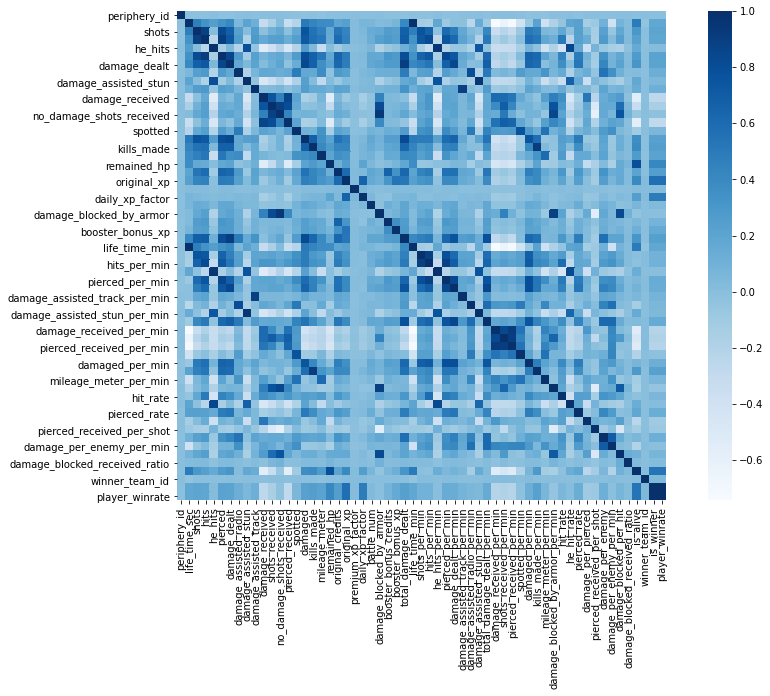

In [26]:
correlations = corr_players_data.corr()

plt.figure(figsize=(15, 9))
sns.heatmap(correlations, square=True, cmap='Blues')
plt.show()

In [27]:
winrate_correlations = correlations['player_winrate']
winrate_correlations[abs(winrate_correlations) >= 0.2].sort_values()

pierced_received           -0.274646
damage_received            -0.255224
pierced_received_per_min   -0.216567
damage_received_per_min    -0.214472
damage_dealt                0.207437
mileage_meter               0.218547
pierced                     0.219160
damaged                     0.226007
kills_made_per_min          0.229300
total_damage_dealt          0.242805
kills_made                  0.254348
original_credits            0.254467
remained_hp                 0.416571
daily_xp_factor             0.493384
is_alive                    0.540539
original_xp                 0.571357
is_winner                   1.000000
player_winrate              1.000000
Name: player_winrate, dtype: float64

### Specify win_rates for players with >= 10 battles

In [28]:
new_data = data[data.groupby('arena_id')['account_db_id'].transform('count') == 30]

In [29]:
new_data.isna().sum()

dt                               0
arena_id                         0
periphery_id                     0
account_db_id                    0
team_id                          0
                                ..
damage_blocked_per_hit           0
damage_blocked_received_ratio    0
is_alive                         0
winner_team_id                   0
is_winner                        0
Length: 66, dtype: int64

In [30]:
players_for_train = new_data[new_data.groupby('account_db_id')
                             ['account_db_id'].transform('count') >= 10][['account_db_id',
                                                                          'kills_made',
                                                                          'total_damage_dealt',
                                                                          'original_xp', 
                                                                          'is_winner']]
players_for_train

,account_db_id,kills_made,total_damage_dealt,original_xp,is_winner
0,cyNd17y1T,2,3075,2790,True
7,cdyN74Ndd,2,2401,2686,True
8,cac4a2121,2,1659,734,True
12,caa4TTcdc,0,81,164,False
14,c27NcNy1d,2,1012,1660,True
...,...,...,...,...,...
2427232,ccaada24T,0,0,284,True
2427233,cc2aacy12,0,481,2007,True
2427237,cyaNa1y41,1,2076,712,False
2427240,cdNc2N1aa,0,1011,380,False


In [31]:
players_for_train = players_for_train.groupby('account_db_id').agg({'original_xp' : ['mean', 'median'],
                                                                    'kills_made': 'mean',
                                                                    'total_damage_dealt': 'mean',
                                                                    'is_winner' : lambda g: sum(g) / len(g)})
players_for_train.columns = ['mean_original_xp', 'median_original_xp', 
                             'mean_kills_made', 'mean_total_damage',
                             'player_winrate']
players_for_train.dropna(axis=0, inplace=True);

In [32]:
players_for_train

,mean_original_xp,median_original_xp,mean_kills_made,mean_total_damage,player_winrate
account_db_id,,,,,
c21114Naa,669.600000,604.0,1.000000,1735.000000,0.600000
c21117yd2,1258.700000,590.5,0.500000,1830.800000,0.500000
c2111Ncyd,1456.937500,1201.0,1.062500,2285.625000,0.562500
c2111TTa7,267.923077,180.0,0.307692,469.692308,0.230769
c2111ad1c,905.571429,540.0,0.571429,1051.642857,0.285714
...,...,...,...,...,...
cyyyydN4N,717.600000,252.0,0.400000,792.800000,0.400000
cyyyydyNa,1348.230769,586.0,0.461538,958.923077,0.461538
cyyyyy2y2,1387.592593,991.0,0.703704,1642.666667,0.629630


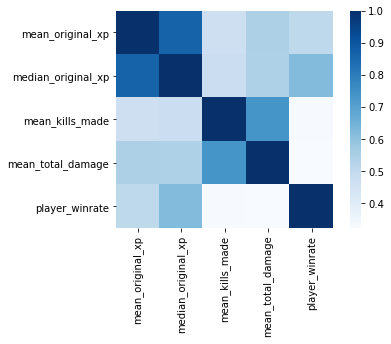

In [33]:
plt.figure()
sns.heatmap(players_for_train.corr(), square=True, cmap='Blues')

plt.show()

In [34]:
mean_scaler = StandardScaler()
median_scaler = StandardScaler()

mean_dataset = players_for_train[['mean_original_xp', 'mean_kills_made', 
                                  'mean_total_damage']]

median_dataset = players_for_train[['median_original_xp', 'mean_kills_made', 
                                    'mean_total_damage']]

Xn_mean = mean_scaler.fit_transform(mean_dataset)
Xn_median = median_scaler.fit_transform(median_dataset)

Yn = players_for_train[['player_winrate']].values
# Xn_mean = mean_scaler.fit_transform(players_for_train[['mean_original_xp']])
# Xn_median = median_scaler.fit_transform(players_for_train[['median_original_xp']])

# Yn = players_for_train[['player_winrate']].values

mean_pca_model = PCA()
Xn_mean = mean_pca_model.fit_transform(Xn_mean)

median_pca_model = PCA()
Xn_median = median_pca_model.fit_transform(Xn_median)

#### Gradient Boosting model - Grid Search (for mean and medin win rates)

In [ ]:
data_types = ['mean_wr', 'median_wr']
X_train = [Xn_mean, Xn_median]
Y_train = Yn
Y_predicted = dict.fromkeys(data_types)
model_params = dict.fromkeys(data_types)

# Define a grid for GB parameters
gb_model = GradientBoostingRegressor()
gb_parameters = [
    {
        'n_estimators': [10, 50, 100, 150, 200], 
        'max_depth': [2, 4, 8, 16],
        'min_samples_split': [2, 4, 6, 8]
    }
]

for idx, data_type in enumerate(data_types):
    gc_model = GridSearchCV(estimator=gb_model, 
                            param_grid=gb_parameters,
                            cv=10,
                            refit=True,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            verbose=True)
    gc_model.fit(X_train[idx], Y_train.reshape(len(Y_train),))
    
    best_model = gc_model.best_estimator_
    model_params[data_type] = best_model
    print(data_type, gc_model.best_params_)
    
    # Use model with the best parameters to train on the whole dataset
    best_model.fit(X_train[idx], Y_train.reshape(len(Y_train),))        
    Y_pred = best_model.predict(X_train[idx])
    Y_predicted[data_type] = Y_pred
    
    print(data_type + ' model finished')

#### Best GB model for mean win_rate

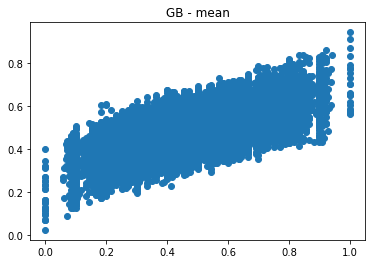

0.012341141656638244


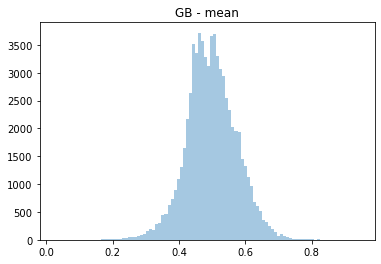

In [35]:
# mean_model = model_params['mean_wr']
mean_model = GradientBoostingRegressor(n_estimators=100, 
                                       max_depth=8,
                                       min_samples_split=8)
mean_model.fit(Xn_mean, Yn.reshape(len(Yn),))
preds_mean = mean_model.predict(Xn_mean)

# plt.scatter(Xn_mean, Yn, color='gray')
# plt.scatter(Xn_mean, preds_mean, color='red')
plt.scatter(Yn, preds_mean);
plt.title('GB - mean');
plt.show()

sns.distplot(preds_mean, kde=False, bins=100);
plt.title('GB - mean');

print(mean_squared_error(Yn, preds_mean));

#### Best GB model for median win_rate

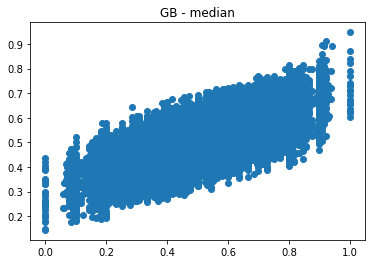

0.00964115981479022


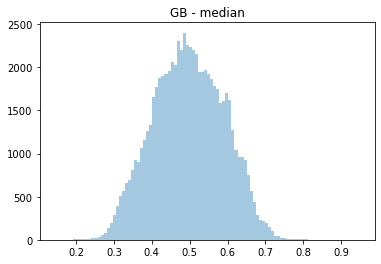

In [36]:
# median_model = model_params['median_wr']
median_model = GradientBoostingRegressor(n_estimators=100, 
                                         max_depth=8,
                                         min_samples_split=6)

median_model.fit(Xn_median, Yn.reshape(len(Yn),))
preds_median = median_model.predict(Xn_median)

# plt.scatter(Xn_median, Yn, color='gray')
# plt.scatter(Xn_median, preds_median, color='red')
plt.scatter(Yn, preds_median);
plt.title('GB - median');
plt.show()

sns.distplot(preds_median, kde=False, bins=100);
plt.title('GB - median');

print(mean_squared_error(Yn, preds_median));

### Predict win_rates for players with < 10 battles

In [37]:
players_for_test = new_data[new_data.groupby('account_db_id')
                            ['account_db_id'].transform('count') < 10][['account_db_id',
                                                                        'kills_made',
                                                                        'total_damage_dealt',
                                                                        'original_xp', 
                                                                        'is_winner']]
players_for_test = players_for_test.groupby('account_db_id').agg({
    'original_xp' : ['mean', 'median'],
    'kills_made': 'mean',
    'total_damage_dealt': 'mean',
    'is_winner' : lambda g: sum(g) / len(g)})
players_for_test.columns = ['mean_original_xp', 'median_original_xp',
                            'mean_kills_made', 'mean_damage_dealt',
                            'player_winrate']
players_for_test.dropna(axis=0, inplace=True)
players_for_test

,mean_original_xp,median_original_xp,mean_kills_made,mean_damage_dealt,player_winrate
account_db_id,,,,,
c211112yy,202.000,202.0,1.000000,2470.500,0.0
c21111dNy,4697.000,4697.0,3.500000,3976.500,1.0
c211122N4,797.000,797.0,0.000000,1366.000,0.0
c21112TT1,865.500,715.0,0.666667,1617.000,0.5
c21112aa2,1943.000,1943.0,0.500000,1622.000,1.0
...,...,...,...,...,...
cyyyyyT74,914.875,757.5,0.375000,1093.125,0.5
cyyyyyd1a,241.000,241.0,0.000000,595.000,0.0
cyyyyyd1c,2005.500,2005.5,3.500000,3548.000,1.0


In [38]:
# Predict using mean values
mean_test_dataset = players_for_test[['mean_original_xp', 'mean_kills_made', 
                                      'mean_damage_dealt']]
Xn_mean_test = mean_scaler.transform(mean_test_dataset)
Xn_mean_test = mean_pca_model.transform(Xn_mean_test)
Yn_mean_predicted = mean_model.predict(Xn_mean_test)

# Predict using median values
median_test_dataset = players_for_test[['median_original_xp', 'mean_kills_made', 
                                        'mean_damage_dealt']]
Xn_median_test = median_scaler.transform(median_test_dataset)
Xn_median_test = median_pca_model.transform(Xn_median_test)
Yn_median_predicted = median_model.predict(Xn_median_test)

# Xn_median_test = median_scaler.transform(players_for_test[['median_original_xp']])

#### Compare results from learning on mean and median values

In [39]:
players_for_train['player_winrate_mean'] = preds_mean
players_for_train['player_winrate_median'] = preds_median
players_for_train.drop('player_winrate', axis=1, inplace=True)

players_for_test['player_winrate_mean'] = Yn_mean_predicted
players_for_test['player_winrate_median'] = Yn_median_predicted
players_for_test.drop('player_winrate', axis=1, inplace=True)

In [40]:
players_for_train

,mean_original_xp,median_original_xp,mean_kills_made,mean_total_damage,player_winrate_mean,player_winrate_median
account_db_id,,,,,,
c21114Naa,669.600000,604.0,1.000000,1735.000000,0.455385,0.452962
c21117yd2,1258.700000,590.5,0.500000,1830.800000,0.506528,0.419206
c2111Ncyd,1456.937500,1201.0,1.062500,2285.625000,0.564525,0.580616
c2111TTa7,267.923077,180.0,0.307692,469.692308,0.264321,0.286023
c2111ad1c,905.571429,540.0,0.571429,1051.642857,0.460659,0.422852
...,...,...,...,...,...,...
cyyyydN4N,717.600000,252.0,0.400000,792.800000,0.433298,0.332479
cyyyydyNa,1348.230769,586.0,0.461538,958.923077,0.542252,0.466351
cyyyyy2y2,1387.592593,991.0,0.703704,1642.666667,0.540393,0.551259


In [41]:
players_data = pd.concat([players_for_train, players_for_test])
data = data.merge(players_data[['player_winrate_mean', 
                                'player_winrate_median']], how='left', on='account_db_id')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2427243 entries, 0 to 2427242
Data columns (total 68 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   dt                               datetime64[ns]
 1   arena_id                         object        
 2   periphery_id                     int64         
 3   account_db_id                    object        
 4   team_id                          int64         
 5   clan_db_id                       int64         
 6   prebattle_id                     int64         
 7   is_prebattle_creator             int64         
 8   vehicle_type_cd                  int64         
 9   life_time_sec                    int64         
 10  shots                            int64         
 11  hits                             int64         
 12  he_hits                          int64         
 13  pierced                          int64         
 14  damage_dealt                     i

#### Plot results from learning on mean and median values

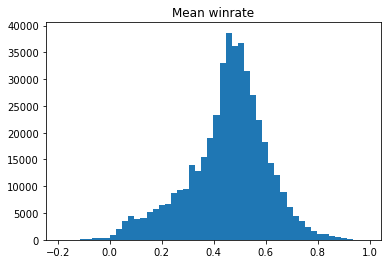

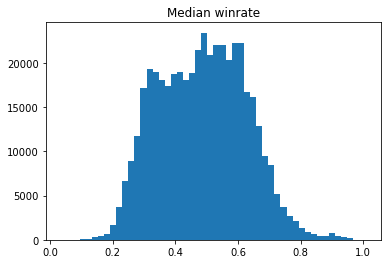

In [43]:
plt.hist(players_data['player_winrate_mean'], bins=50);
plt.title('Mean winrate');
plt.show();

plt.hist(players_data['player_winrate_median'], bins=50);
plt.title('Median winrate');
plt.show();

#### Check min_battle_threshold to remove outliers

c:\users\darya\python_env_darya\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\darya\python_env_darya\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


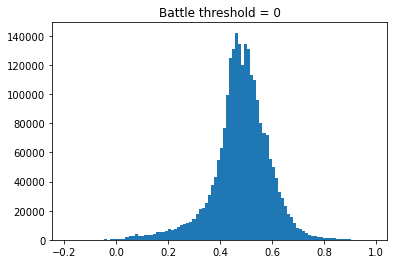

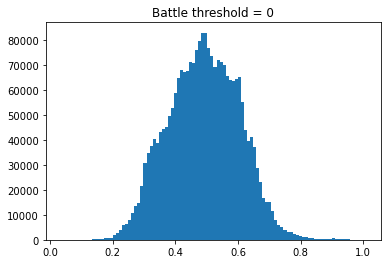

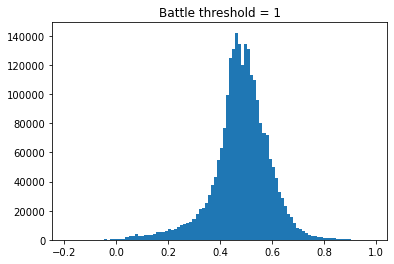

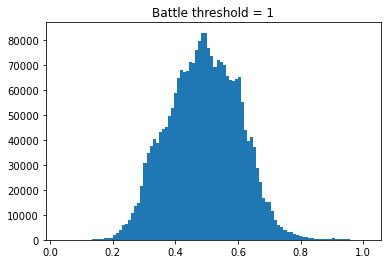

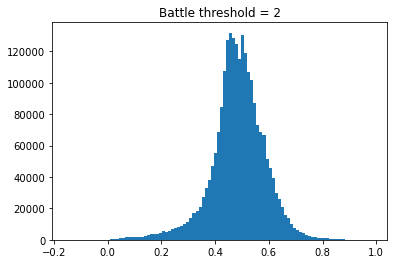

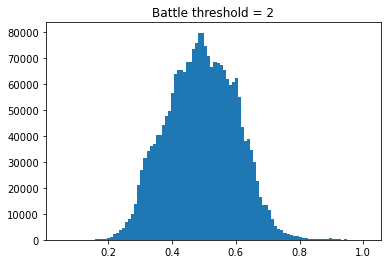

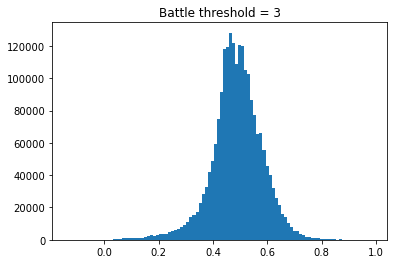

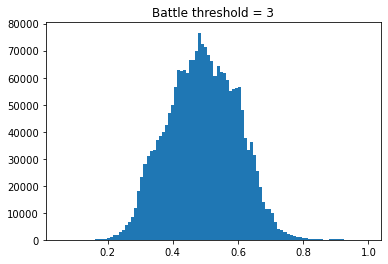

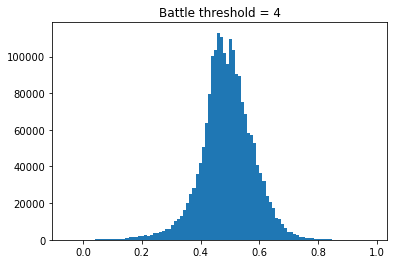

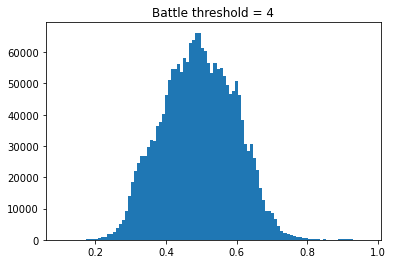

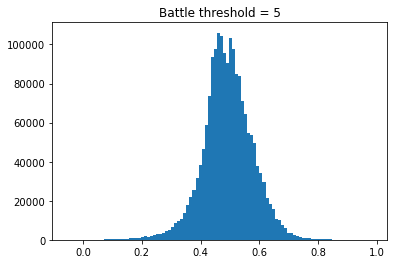

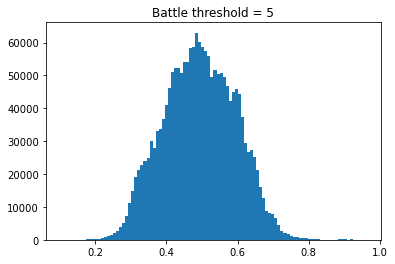

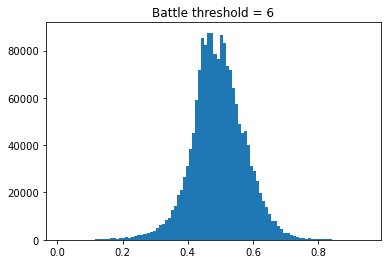

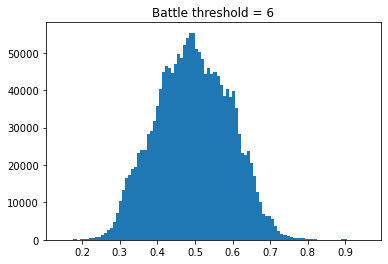

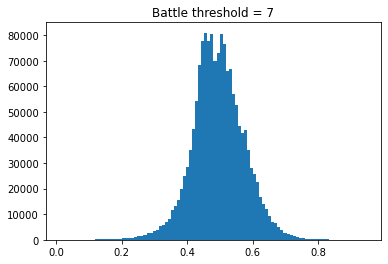

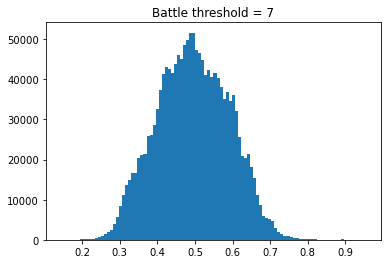

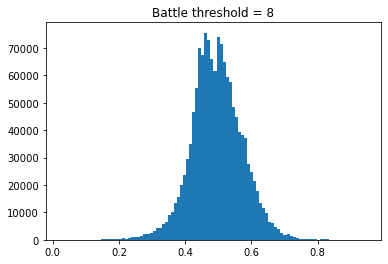

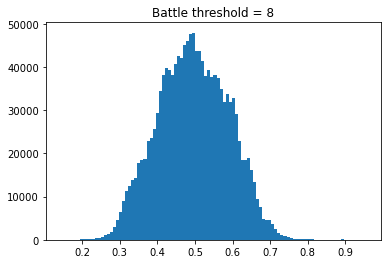

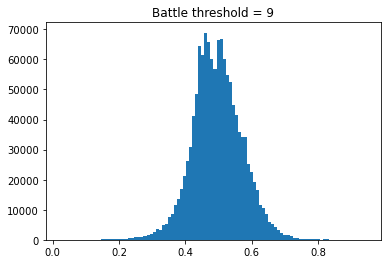

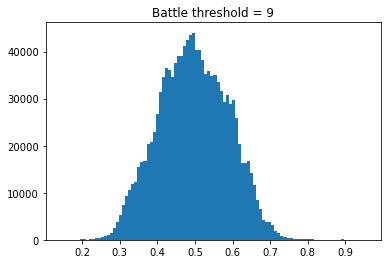

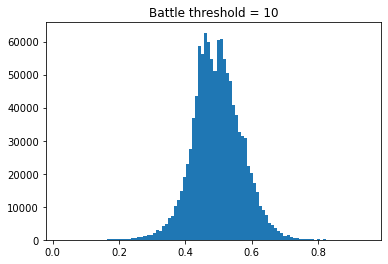

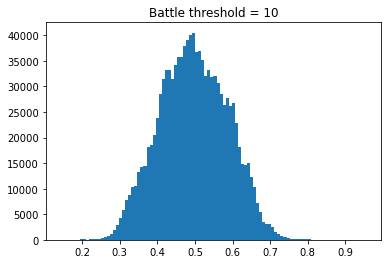

In [44]:
battle_thresholds = np.arange(11)

for battle_threshold in battle_thresholds:
    new_mean_data = data[data.groupby('account_db_id')
                         ['account_db_id'].
                         transform('count') >= battle_threshold]['player_winrate_mean']
    plt.hist(new_mean_data, bins=100);
    plt.title('Battle threshold = ' + str(battle_threshold));
    plt.show();

    new_data_median = data[data.groupby('account_db_id')
                           ['account_db_id'].
                           transform('count') >= battle_threshold]['player_winrate_median']
    plt.hist(new_data_median, bins=100);
    plt.title('Battle threshold = ' + str(battle_threshold));
    plt.show();

Select only players with >= 4 battles

In [45]:
data = data[data.groupby('account_db_id')['account_db_id'].
            transform('count') >= 3]

## Calculate tank win_rates

### Remove tanks with battles < 100

In [46]:
data = data[data.groupby('vehicle_type_cd')['vehicle_type_cd'].transform('count') >= 100]

### Calculate mean and median win_rates for tanks

In [47]:
tanks_data = data.groupby('vehicle_type_cd')[['original_xp',
                                              'is_winner']].agg({'original_xp' : ['mean', 'median'],
                                                                 'is_winner' : lambda g: sum(g) / len(g)})
tanks_data.columns = ['mean_original_xp', 'median_original_xp', 'tank_winrate']
tanks_data.dropna(axis=0, inplace=True)
tanks_data

,mean_original_xp,median_original_xp,tank_winrate
vehicle_type_cd,,,
49,1235.334360,838.0,0.496064
145,1002.098160,727.0,0.484663
273,680.757732,444.5,0.461340
305,1132.924606,787.0,0.516984
513,812.817359,525.0,0.497463
...,...,...,...
64065,1207.515102,811.0,0.498851
64273,1117.732078,671.5,0.464156
64561,1188.292577,806.0,0.497555


In [48]:
data = data.merge(tanks_data['tank_winrate'], how='left', on='vehicle_type_cd')
data

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,damage_per_enemy,damage_per_enemy_per_min,damage_blocked_per_hit,damage_blocked_received_ratio,is_alive,winner_team_id,is_winner,player_winrate_mean,player_winrate_median,tank_winrate
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,512.500000,81.134565,0,0,True,2.0,True,0.582722,0.601896,0.496884
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,869.000000,137.572559,0,0,True,2.0,True,0.501727,0.531968,0.442142
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,283.333333,48.850575,257,0,False,2.0,False,0.319000,0.328876,0.506868
3,2018-09-16,7N1T221ccNyadyccT,202,cd1T171cy,1,0,0,0,7457,295,...,346.333333,70.440678,0,0,False,2.0,False,0.210662,0.331867,0.496884
4,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,480.200000,85.495549,327,0,False,2.0,True,0.485375,0.562054,0.494928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167120,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,688.500000,230.782123,260,1,False,1.0,False,0.439573,0.422604,0.479324
2167121,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,654.750000,128.382353,596,1,False,1.0,True,0.596800,0.576576,0.488748
2167122,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,1011.000000,181.616766,97,0,False,1.0,False,0.624844,0.630997,0.518681
2167123,2018-10-10,cTacc2711d4da4y,202,c44d7NNNa,2,500138173,0,0,15649,336,...,3097.000000,553.035714,0,0,False,1.0,False,0.478319,0.415260,0.498453


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167125 entries, 0 to 2167124
Data columns (total 69 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   dt                               datetime64[ns]
 1   arena_id                         object        
 2   periphery_id                     int64         
 3   account_db_id                    object        
 4   team_id                          int64         
 5   clan_db_id                       int64         
 6   prebattle_id                     int64         
 7   is_prebattle_creator             int64         
 8   vehicle_type_cd                  int64         
 9   life_time_sec                    int64         
 10  shots                            int64         
 11  hits                             int64         
 12  he_hits                          int64         
 13  pierced                          int64         
 14  damage_dealt                     i

## Create new features (normalized to win_rate)

In [50]:
new_data = data[['vehicle_type_cd', 'account_db_id', 'original_credits', 
                 'damage_dealt', 'damage_assisted_radio', 
                 'damage_assisted_track','damage_blocked_by_armor', 
                 'player_winrate_mean']]
new_data = new_data.rename(columns={"player_winrate_mean": "player_winrate"})
new_data

,vehicle_type_cd,account_db_id,original_credits,damage_dealt,damage_assisted_radio,damage_assisted_track,damage_blocked_by_armor,player_winrate
0,7457,cyNd17y1T,35286,1879,0,0,0,0.582722
1,5377,c2c1cN211,26896,2230,377,0,0,0.501727
2,3873,ca7N4y2y1,11202,850,0,0,1030,0.319000
3,7457,cd1T171cy,9226,618,0,0,0,0.210662
4,2961,cdyN74Ndd,36788,1786,615,0,1310,0.485375
...,...,...,...,...,...,...,...,...
2167120,9217,cdNNTdcca,54366,1377,0,0,1560,0.439573
2167121,65073,ccaT7TTc1,73469,1479,1140,0,1790,0.596800
2167122,59137,cdNc2N1aa,20699,107,420,484,390,0.624844
2167123,15649,c44d7NNNa,21841,171,2926,0,0,0.478319


Check mean and median win_rates

In [51]:
f = new_data.groupby(['vehicle_type_cd', 'account_db_id'])[['damage_dealt',
                                                            'damage_assisted_radio',
                                                            'damage_assisted_track',
                                                            'damage_blocked_by_armor',
                                                            'original_credits',
                                                            'player_winrate']].mean()

f['normed_damage_dealt'] = (1 - f['player_winrate']) * f['damage_dealt']
f['normed_damage_assisted_radio'] = (1 - f['player_winrate']) * f['damage_assisted_radio']
f['normed_damage_assisted_track'] = (1 - f['player_winrate']) * f['damage_assisted_track']
f['normed_damage_blocked_by_armor'] = (1 - f['player_winrate']) * f['damage_blocked_by_armor']
f['normed_original_credits'] = (1 - f['player_winrate']) * f['original_credits']

f = f.groupby(level=0)[['normed_damage_dealt', 'normed_damage_assisted_radio',
                        'normed_damage_assisted_track', 'normed_damage_blocked_by_armor', 
                        'normed_original_credits']].mean()

f

,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,normed_original_credits
vehicle_type_cd,,,,,
49,465.332416,213.804891,40.694773,223.862781,23036.323124
145,234.741890,116.882426,15.881580,71.601639,10252.967718
273,342.799666,9.428893,20.595568,0.278839,10236.015231
305,286.759191,307.232933,20.424441,11.798086,15625.859096
513,336.915152,120.041157,27.371717,143.114796,8919.829302
...,...,...,...,...,...
64065,466.601723,169.835058,38.416271,107.673854,20179.681467
64273,390.703325,183.653077,30.721651,64.051135,18905.921350
64561,462.185964,166.602066,34.461510,529.739540,21414.989195


In [52]:
data = data.merge(f, how='left', on='vehicle_type_cd')
data

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,winner_team_id,is_winner,player_winrate_mean,player_winrate_median,tank_winrate,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,normed_original_credits
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,2.0,True,0.582722,0.601896,0.496884,608.666734,8.735318,17.136973,1.010242,9799.409324
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,2.0,True,0.501727,0.531968,0.442142,520.134648,142.192065,34.629549,351.993286,10156.843078
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,2.0,False,0.319000,0.328876,0.506868,389.964305,152.828945,30.008422,267.874475,8496.823824
3,2018-09-16,7N1T221ccNyadyccT,202,cd1T171cy,1,0,0,0,7457,295,...,2.0,False,0.210662,0.331867,0.496884,608.666734,8.735318,17.136973,1.010242,9799.409324
4,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,2.0,True,0.485375,0.562054,0.494928,573.366351,135.208111,37.447211,293.070207,11981.592272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167120,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,1.0,False,0.439573,0.422604,0.479324,469.046384,151.884727,38.261763,406.462626,20044.080453
2167121,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,1.0,True,0.596800,0.576576,0.488748,450.392263,161.416556,35.090352,394.767712,22511.484858
2167122,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,1.0,False,0.624844,0.630997,0.518681,330.346536,116.569350,20.632852,114.156768,14155.224049
2167123,2018-10-10,cTacc2711d4da4y,202,c44d7NNNa,2,500138173,0,0,15649,336,...,1.0,False,0.478319,0.415260,0.498453,287.108562,249.485239,17.221848,1.492302,7583.933196


# Additional data preparation

## Merge "data" with "catalog"

In [53]:
data = data.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
data.drop(['item_cd'], axis=1, inplace=True)

## Remove redundant features

In [54]:
redundant_features = ['premium_xp_factor', 'daily_xp_factor', 'is_prebattle_creator',
                     'dt', 'team_id', 'remained_hp', 'is_alive', 'winner_team_id', 'is_winner']
data.drop(redundant_features, axis=1, inplace=True)

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167125 entries, 0 to 2167124
Data columns (total 70 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   arena_id                         object 
 1   periphery_id                     int64  
 2   account_db_id                    object 
 3   clan_db_id                       int64  
 4   prebattle_id                     int64  
 5   vehicle_type_cd                  int64  
 6   life_time_sec                    int64  
 7   shots                            int64  
 8   hits                             int64  
 9   he_hits                          int64  
 10  pierced                          int64  
 11  damage_dealt                     int64  
 12  damage_assisted_radio            int64  
 13  damage_assisted_stun             int64  
 14  damage_assisted_track            int64  
 15  damage_received                  int64  
 16  shots_received                   int64  
 17  no_damag

## Removing "away-from-keyboard" players

In [ ]:
afk_players = (data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)
data = data.loc[~afk_players]
data.reset_index(inplace=True, drop=True)

## Group "data" by vehicle_type_cd and calculate mean

In [94]:
new_data = data.groupby('vehicle_type_cd')[['vehicle_type_cd', 'item_class', 
                                            'item_level', 'tank_winrate',
                                            'normed_damage_dealt',  
                                            'normed_damage_assisted_track',
                                            'normed_damage_assisted_radio',
                                            'normed_damage_blocked_by_armor',
                                            'item_price_credit', 
                                            'item_price_gold']].mean()

new_data.reset_index(drop=True, inplace=True)

In [95]:
dataset = new_data

In [96]:
dataset

,vehicle_type_cd,item_class,item_level,tank_winrate,normed_damage_dealt,normed_damage_assisted_track,normed_damage_assisted_radio,normed_damage_blocked_by_armor,item_price_credit,item_price_gold
0,49,4,8,0.496064,465.332416,40.694773,213.804891,223.862781,0,7500
1,145,4,6,0.484663,234.741890,15.881580,116.882426,71.601639,0,3650
2,273,1,6,0.461340,342.799666,20.595568,9.428893,0.278839,930000,0
3,305,3,7,0.516984,286.759191,20.424441,307.232933,11.798086,0,4800
4,513,2,7,0.497463,336.915152,27.371717,120.041157,143.114796,1424000,0
...,...,...,...,...,...,...,...,...,...,...
309,64065,2,8,0.498851,466.601723,38.416271,169.835058,107.673854,0,11900
310,64273,4,8,0.464156,390.703325,30.721651,183.653077,64.051135,0,8700
311,64561,2,8,0.497555,462.185964,34.461510,166.602066,529.739540,0,10500
312,64817,3,6,0.352014,229.241007,10.705382,192.788266,0.525951,0,3500


# Preparing data for regression

## Creating regression dataset

In [97]:
regression_dataset = dataset.groupby('vehicle_type_cd').mean()

In [98]:
regression_dataset

,item_class,item_level,tank_winrate,normed_damage_dealt,normed_damage_assisted_track,normed_damage_assisted_radio,normed_damage_blocked_by_armor,item_price_credit,item_price_gold
vehicle_type_cd,,,,,,,,,
49,4,8,0.496064,465.332416,40.694773,213.804891,223.862781,0,7500
145,4,6,0.484663,234.741890,15.881580,116.882426,71.601639,0,3650
273,1,6,0.461340,342.799666,20.595568,9.428893,0.278839,930000,0
305,3,7,0.516984,286.759191,20.424441,307.232933,11.798086,0,4800
513,2,7,0.497463,336.915152,27.371717,120.041157,143.114796,1424000,0
...,...,...,...,...,...,...,...,...,...
64065,2,8,0.498851,466.601723,38.416271,169.835058,107.673854,0,11900
64273,4,8,0.464156,390.703325,30.721651,183.653077,64.051135,0,8700
64561,2,8,0.497555,462.185964,34.461510,166.602066,529.739540,0,10500


## Regression model (Egor)

In [99]:
tank_params = regression_dataset[regression_dataset.index == 9217]
res_data = regression_dataset[regression_dataset.index != 9217]

features = list(res_data.columns)
features.remove('item_price_credit'); features.remove('item_price_gold')
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

credit_dataset.index = np.arange(len(credit_dataset))
gold_dataset.index = np.arange(len(gold_dataset))

gold_dataset

,item_class,item_level,tank_winrate,normed_damage_dealt,normed_damage_assisted_track,normed_damage_assisted_radio,normed_damage_blocked_by_armor,item_price_gold
0,4,8,0.496064,465.332416,40.694773,213.804891,223.862781,7500
1,4,6,0.484663,234.741890,15.881580,116.882426,71.601639,3650
2,3,7,0.516984,286.759191,20.424441,307.232933,11.798086,4800
3,2,8,0.501851,487.050668,39.883062,187.188982,400.581815,12250
4,2,8,0.496611,586.402795,33.329725,151.953265,379.350822,10700
...,...,...,...,...,...,...,...,...
82,2,8,0.498851,466.601723,38.416271,169.835058,107.673854,11900
83,4,8,0.464156,390.703325,30.721651,183.653077,64.051135,8700
84,2,8,0.497555,462.185964,34.461510,166.602066,529.739540,10500
85,3,6,0.352014,229.241007,10.705382,192.788266,0.525951,3500


In [100]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), 
                                     columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), 
                                   columns=[features + target_gold])

normed_gold_dataset

,item_class,item_level,tank_winrate,normed_damage_dealt,normed_damage_assisted_track,normed_damage_assisted_radio,normed_damage_blocked_by_armor,item_price_gold
0,1.044074,0.452470,0.505650,0.043152,0.720522,0.660063,0.123915,-0.310770
1,1.044074,-2.087202,0.102184,-1.391791,-1.327296,-0.821717,-0.686757,-1.382339
2,0.355934,-0.817366,1.245986,-1.068092,-0.952377,2.088419,-1.005164,-1.062260
3,-0.332205,0.452470,0.710463,0.178302,0.653532,0.253151,1.064806,1.011297
4,-0.332205,0.452470,0.525008,0.796561,0.112689,-0.285544,0.951768,0.579886
...,...,...,...,...,...,...,...,...
82,-0.332205,0.452470,0.604283,0.051051,0.532479,-0.012161,-0.494700,0.913882
83,1.044074,0.452470,-0.623490,-0.421258,-0.102554,0.199093,-0.726957,0.023226
84,-0.332205,0.452470,0.558408,0.023572,0.206095,-0.061588,1.752470,0.524220
85,0.355934,-2.087202,-4.591995,-1.426023,-1.754485,0.338754,-1.065179,-1.424089


In [101]:
train_data = np.array(normed_gold_dataset.drop(columns=['item_price_gold']))
train_labels = np.array(normed_gold_dataset[['item_price_gold']])

c:\users\darya\python_env_darya\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [102]:
epochs = 100

model = build_model(train_data.shape[1])
history = model.fit(train_data, train_labels,
                    validation_split=0.15,
                    epochs=epochs, shuffle=True)

Train on 73 samples, validate on 14 samples
Epoch 1/100
73/73 [==============================] - 0s 5ms/sample - loss: 1.0128 - val_loss: 0.3948
Epoch 2/100
73/73 [==============================] - 0s 136us/sample - loss: 0.7847 - val_loss: 0.3200
Epoch 3/100
73/73 [==============================] - 0s 150us/sample - loss: 0.5583 - val_loss: 0.2683
Epoch 4/100
73/73 [==============================] - 0s 178us/sample - loss: 0.4802 - val_loss: 0.2481
Epoch 5/100
73/73 [==============================] - 0s 150us/sample - loss: 0.4389 - val_loss: 0.2357
Epoch 6/100
73/73 [==============================] - 0s 150us/sample - loss: 0.3383 - val_loss: 0.2134
Epoch 7/100
73/73 [==============================] - 0s 150us/sample - loss: 0.3216 - val_loss: 0.2015
Epoch 8/100
73/73 [==============================] - 0s 150us/sample - loss: 0.3156 - val_loss: 0.1894
Epoch 9/100
73/73 [==============================] - 0s 150us/sample - loss: 0.2970 - val_loss: 0.1754
Epoch 10/100
73/73 [===========

73/73 [==============================] - 0s 219us/sample - loss: 0.0577 - val_loss: 0.1405
Epoch 80/100
73/73 [==============================] - 0s 164us/sample - loss: 0.0667 - val_loss: 0.1475
Epoch 81/100
73/73 [==============================] - 0s 164us/sample - loss: 0.0599 - val_loss: 0.1376
Epoch 82/100
73/73 [==============================] - 0s 219us/sample - loss: 0.0548 - val_loss: 0.1499
Epoch 83/100
73/73 [==============================] - 0s 137us/sample - loss: 0.0846 - val_loss: 0.1455
Epoch 84/100
73/73 [==============================] - 0s 178us/sample - loss: 0.0461 - val_loss: 0.1441
Epoch 85/100
73/73 [==============================] - 0s 219us/sample - loss: 0.0718 - val_loss: 0.1441
Epoch 86/100
73/73 [==============================] - 0s 219us/sample - loss: 0.0707 - val_loss: 0.1498
Epoch 87/100
73/73 [==============================] - 0s 150us/sample - loss: 0.0486 - val_loss: 0.1366
Epoch 88/100
73/73 [==============================] - 0s 191us/sample - loss:

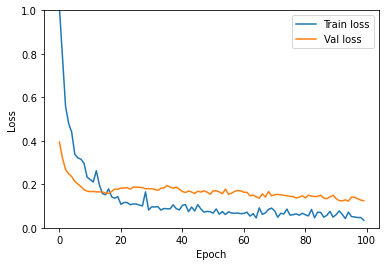

In [103]:
plot_history(model)

In [104]:
full_model = build_model(train_data.shape[1])
history = full_model.fit(train_data, train_labels,
                         epochs=100, shuffle=True)

Train on 87 samples
Epoch 1/100
87/87 [==============================] - 0s 4ms/sample - loss: 0.9908
Epoch 2/100
87/87 [==============================] - 0s 57us/sample - loss: 0.7780
Epoch 3/100
87/87 [==============================] - 0s 57us/sample - loss: 0.5909
Epoch 4/100
87/87 [==============================] - 0s 57us/sample - loss: 0.4999
Epoch 5/100
87/87 [==============================] - 0s 46us/sample - loss: 0.4877
Epoch 6/100
87/87 [==============================] - 0s 46us/sample - loss: 0.3856
Epoch 7/100
87/87 [==============================] - 0s 45us/sample - loss: 0.4122
Epoch 8/100
87/87 [==============================] - 0s 46us/sample - loss: 0.3425
Epoch 9/100
87/87 [==============================] - 0s 45us/sample - loss: 0.2769
Epoch 10/100
87/87 [==============================] - 0s 57us/sample - loss: 0.2343
Epoch 11/100
87/87 [==============================] - 0s 57us/sample - loss: 0.2076
Epoch 12/100
87/87 [==============================] - 0s 46us/samp

87/87 [==============================] - 0s 57us/sample - loss: 0.0348
Epoch 99/100
87/87 [==============================] - 0s 69us/sample - loss: 0.0462
Epoch 100/100
87/87 [==============================] - 0s 46us/sample - loss: 0.0267


In [105]:
tank_params.drop(columns=['item_price_credit', 'item_price_gold'], inplace=True, axis=1)
tank_params

c:\users\darya\python_env_darya\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,item_class,item_level,tank_winrate,normed_damage_dealt,normed_damage_assisted_track,normed_damage_assisted_radio,normed_damage_blocked_by_armor
vehicle_type_cd,,,,,,,
9217,2,8,0.479324,469.046384,38.261763,151.884727,406.462626


In [106]:
def predict(tank_params):
    tank_params['item_price_gold'] = 0
    
    scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
    
    pred_full = full_model.predict(scaled)
    pred = model.predict(scaled)
    
    x_full = np.concatenate((scaled[0], pred_full[0]))
    x = np.concatenate((scaled[0], pred[0]))
    
    return gold_scaler.inverse_transform(x_full)[-1], gold_scaler.inverse_transform(x)[-1]

predict(tank_params)

c:\users\darya\python_env_darya\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(10994.269979181741, 10547.14962222633)

## Regression models (Dasha)

### Create different models

In [107]:
key_tank_id = 9217

regression_gold_dataset = regression_dataset[regression_dataset['item_price_gold'] > 0]

regression_gold_target = regression_gold_dataset['item_price_gold']
regression_gold_features = regression_gold_dataset.drop(['item_price_gold', 'item_price_credit'], axis=1)

# Select only data that corresponds to tank_id = 9217
key_tank_features = regression_gold_features[regression_gold_features.index == 
                                            key_tank_id]
key_tank_target = regression_gold_target[regression_gold_target.index == 
                                          key_tank_id]
# Remove this selection from the regression dataset
regression_features = regression_gold_features[regression_gold_features.index != 
                                               key_tank_id]
regression_target = regression_gold_target[regression_gold_target.index != 
                                           key_tank_id]

Introducing different regression models

In [108]:
models = [RandomForestRegressor(), 
          GradientBoostingRegressor(),
          SVR(),
          SVR(),
          SVR()]

parameters = [
    {'n_estimators': [10, 50, 100], 'max_depth': [2, 4, 6, 8, 10],
     'min_samples_split': [2, 4, 6, 8]},
    {'n_estimators': [10, 50, 100], 'max_depth': [2, 4, 6, 8, 10],
     'min_samples_split': [2, 4, 6, 8]},
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 0.00001], 
     'kernel': ['rbf']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 
     'degree': [3], 'coef0': [0, 1, 10, 100], 'kernel': ['poly']}
 ]

model_names = ['RandomForest', 'GradientBoost', 'SVM_linear', 'SVM_rbf', 'SVM_poly']

In [109]:
is_target_scaled=True
is_pca_used=True

scores = ['MSE', 'RMSE', 'MAE']
regression_scores = np.zeros((len(models), len(scores)))

# Starting regression analysis
x_train = regression_features
y_train = regression_target
x_test = key_tank_features
y_test = key_tank_target

scaler = StandardScaler()
# Scaling features
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

if is_target_scaled:
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
else:
    y_train_scaled = y_train
    y_test_scaled = y_test

# Removing collinearity between features
if is_pca_used:
    pca_model = PCA(n_components=0.95)
    x_train_pca = pca_model.fit_transform(x_train_scaled)
    x_test_pca = pca_model.transform(x_test_scaled)
else:
    x_train_pca = x_train_scaled
    x_test_pca = x_test_scaled
    
results = y_test_scaled.reshape(-1, 1)
for idx, model in enumerate(models):
    gc_model = GridSearchCV(estimator=model, 
                            param_grid=parameters[idx],
                            cv=10,
                            refit=True,
                            scoring='neg_mean_squared_error',
                            iid=False)
    gc_model.fit(x_train_pca, y_train_scaled)
    
    best_model = gc_model.best_estimator_
    print(model_names[idx], gc_model.best_params_)
    
    # Use model with the best parameters to train on the whole dataset
    best_model.fit(x_train_pca, y_train_scaled)        
    y_predicted = best_model.predict(x_test_pca)
        
    # Saving prediction results
    if is_target_scaled:
        results = np.hstack((results, scaler.inverse_transform(y_predicted).reshape(-1, 1)))
    else:
        results = np.hstack((results, y_predicted.reshape(-1, 1)))
    
    # Saving accuracy scores
    regression_scores[idx, 0] = mean_squared_error(y_test_scaled, y_predicted)
    regression_scores[idx, 1] = np.sqrt(mean_squared_error(y_test_scaled, y_predicted))
    regression_scores[idx, 2] = mean_absolute_error(y_test_scaled, y_predicted)
    
# Saving prediction results
regression_results = pd.DataFrame(data=results, index=x_test.index.values,
                                  columns=['y'] + model_names)
regression_scores = pd.DataFrame(data=regression_scores, index=model_names,
                                 columns=scores)

RandomForest {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 100}
GradientBoost {'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 100}
SVM_linear {'C': 1, 'kernel': 'linear'}
SVM_rbf {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVM_poly {'C': 100, 'coef0': 10, 'degree': 3, 'gamma': 0.0001, 'kernel': 'poly'}


In [110]:
regression_results

,y,RandomForest,GradientBoost,SVM_linear,SVM_rbf,SVM_poly
9217,0.886049,11078.753361,10782.140395,9978.533864,10002.017878,9928.204906


In [111]:
regression_results.values[0][1:].mean()

10353.930080662965

In [112]:
regression_scores

,MSE,RMSE,MAE
RandomForest,0.040298,0.200744,0.200744
GradientBoost,0.080259,0.283301,0.283301
SVM_linear,0.257017,0.506968,0.506968
SVM_rbf,0.250432,0.500432,0.500432
SVM_poly,0.271416,0.520976,0.520976


Visualize best predictions

In [ ]:
for model in model_names:
    best_prediction = mse_scores[model].idxmin()

    targets = [regression_results[best_prediction]['y'],
               regression_results[best_prediction][model]]

    compare_results(targets, [-6_000, 6_000], model)
    
    # Perform PCA and visualize results
    items = regression_features.loc[regression_results[best_prediction][model].index]
    pca_items = perform_pca(items)

    visualize_data(pca_items, targets, model, dr_type='PCA')
    
    # Perform TSNE and visualize results
    tsne_items = TSNE(n_components=2, perplexity=5, learning_rate=10, init='pca').fit_transform(pca_items)
    
    visualize_data(tsne_items, targets, model, dr_type='t-SNE')

## Check battle levels

In [ ]:
# Create a dataframe with 
battle_players = full_battles_data.groupby('arena_id')['item_level'].agg(levels=lambda x: sorted(list(x.unique())), 
                                                                         level_count=pd.Series.nunique)

In [ ]:
battle_players.dropna(axis=0, inplace=True)

In [ ]:
battle_players

The following options are possible:
> level_count = 3: [7, 8, 9], [8, 9, 10], [6, 7, 8]

> level_count = 2: [7, 8], [8, 9]

> level_count = 1: [8]

In [ ]:
battle_players[battle_players['level_count'] == 3]['levels'].value_counts()

In [ ]:
battle_players['battle_level'] = battle_players['levels'].apply(lambda row: max(row))

In [ ]:
new_battle_data = full_battles_data.merge(battle_players['battle_level'], how='left', 
                                          left_on='arena_id', right_on=battle_players.index)

Check mean battle_level for each tank

In [ ]:
tanks = new_battle_data['vehicle_type_cd'].unique()

In [ ]:
tank_params = pd.DataFrame(data=tanks, columns=['tank_id'])
tank_params = tank_params.merge(catalog, how='left',
                               left_on='tank_id', right_on='item_cd')
tank_params.drop(['item_cd'], axis=1, inplace=True)

In [ ]:
tank_params

In [ ]:
mean_battle_levels = new_battle_data.groupby('vehicle_type_cd')['battle_level'].agg(mean_battle_level=np.mean)
new_battle_data = new_battle_data.merge(mean_battle_levels, how='left', 
                                        left_on='vehicle_type_cd', right_on=mean_battle_levels.index)

In [ ]:
new_battle_data.head()

In [ ]:
tank_params = tank_params.merge(mean_battle_levels, how='left', 
                                left_on='tank_id', right_on=mean_battle_levels.index)
tank_params

In [ ]:
sns.scatterplot(x=tank_params['item_level'], y=tank_params['mean_battle_level']);

Check item_level = mean_battle_level = 1

<br> This tank can be removed from the dataset!

In [ ]:
tank_params[(tank_params['item_level'] == 8) & (tank_params['mean_battle_level'] == 8)]

In [ ]:
new_battle_data[new_battle_data['vehicle_type_cd'] == 62481]

What if players used to play in platoons?

In [ ]:
premium_battle_data = new_battle_data[(new_battle_data['item_price_credit'] == 0) & 
                                      (new_battle_data['item_price_gold'] != 0)]

In [ ]:
premium_battle_data.groupby('vehicle_type_cd')['arena_id'].count().sort_values(ascending=False)

In [ ]:
players.dropna(inplace=True)

In [ ]:
player_features = ['hit_rate', 'pierced_rate', 'damage_per_enemy', 
                  'damage_blocked_received_ratio', 'kills_made_per_min',
                  'total_damage_dealt']
players_data = players[player_features]

## Check "battle_num"

In [ ]:
plt.figure(figsize=(8, 6));
sns.distplot(joined_data['battle_num'], kde=False, bins=50);

In [ ]:
def calc_diff(data):
    return data.max() - data.min()

In [ ]:
battle_nums = joined_data.groupby('account_db_id')['battle_num'].agg(['min', 'max', calc_diff, 'count'])
battle_nums['battles_per_day'] = battle_nums['calc_diff'] / 31

In [ ]:
joined_data[joined_]

In [ ]:
battle_nums['calc_diff'].max()

In [ ]:
plt.figure(figsize=(8, 6));
sns.distplot(battle_nums['count'], kde=False, bins=50, norm_hist=True, color='tab:blue');
# sns.distplot(battle_nums['calc_diff'], kde=False, bins=50, norm_hist=True, color='tab:orange');
sns.distplot(battle_nums['battles_per_day'], kde=False, bins=50, norm_hist=True, color='tab:purple');

In [ ]:
nonzero_damage = joined_data[joined_data['total_damage_dealt'] > 0][['account_db_id',
                                                                    'total_damage_dealt', 
                                                                    'total_damage_dealt_per_min']]

In [ ]:
sns.scatterplot(battle_nums['battles_per_day'], 
                nonzero_damage.groupby('account_db_id')['total_damage_dealt'].mean())

In [ ]:
bot_players = battle_nums[battle_nums['calc_diff'] > 5000].index.values

In [ ]:
data[data['account_db_id'].isin(bot_players)]['dt'].value_counts()